In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from time import time
from scipy import stats

In [2]:
def getDirectories(source_directory):
    source_directory = os.path.abspath(source_directory)
    if not os.path.isdir(source_directory):
        exit("That's not a directory!")
    else:
        print(source_directory)

    directories = []
    elems = os.listdir(source_directory)
    for e in elems:
        path = os.path.join(source_directory, e)

        if os.path.isdir(path):
            directories.append(path)
    
    return directories

## Sammeln von CSV Dateien innerhalb eines Verzeichnisses

In [3]:
def gatherCSVFilePathsfromDirectory(dir):
    print(dir)
    filepaths = []
    for f in os.listdir(dir):
        path = os.path.join(dir, f)
        if os.path.isfile(path) and f.endswith(".csv"):
            filepaths.append(path)

    if len(filepaths) == 0:
        exit("Directory does not contain any csv files: %s" % dir)

    filepaths = np.sort(filepaths)
    print("Found %s files." % len(filepaths))

    return filepaths

## Aufbereiten der Daten einer CSV-Datei

In [4]:
def getSanitizedDataFrameFromFile(filepath):
    # read file
    dataframe = pd.read_csv(filepath, header=1)
    dataframe.columns = dataframe.columns.str.strip().str.replace('(', '').str.replace(')', '') 

    # convert ms timestamp to ids
    dataframe = dataframe.assign(id= lambda x: dataframe.index )
    dataframe = dataframe.drop(columns=['ms'])

    if 'mA' in dataframe:
        dataframe = dataframe.assign(A= lambda x: x.mA / 1000.0).drop(columns=['mA'])

    return dataframe

## Einlesen der CSV Dateien aus den verschiedenen Verzeichnissen in eine Map von Listen von Dataframes

In [5]:
def getDataFramesFromDirectory(directory):
    filepaths = gatherCSVFilePathsfromDirectory(directory)

    dataframes = []
    for filepath in filepaths:
        dataframes.append(getSanitizedDataFrameFromFile(filepath))

    return dataframes

In [6]:
SOURCE_DIR = "./data/"

DEVICE_DESCRIPTIONS = {
    "laptop-single": "Laptopnetzteil: Apple 60W MagSafe 2 Power Adapter",
    "ohp_halb-single": "Overhead-Projektor Stufe 1: Liesegang trainer deluxe 400",
    "ohp_voll-single": "Overhead-Projektor Stufe 2: Liesegang trainer deluxe 400",
    "lampe-single": "Handelsübliche 50W Halogenlampe",
    "bosch-single": "Bohrmaschine: Bosch P120 SB"
}

dirs = getDirectories(SOURCE_DIR)
dataframes_per_directory = {}

for path in dirs:
    name = os.path.basename(os.path.normpath(path))
    dataframes_per_directory[name] = getDataFramesFromDirectory(path)

/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/laptop-single
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/ohp_voll-laptop
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/ohp_halb-single
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/lampe-ohp_voll
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/ohp_voll-single
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/bosch-single
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/lampe-single
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/ohp_voll-laptop-bosch-lampe
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/ohp_halb-laptop
Found 256 files.
/Users/Felix/Documents/FH/NILM/DataScienceProjekt/data/ohp_halb-laptop-lampe
Found 256 files.


# Beschaffenheit der Daten (Auszug)

In [7]:
dfs = dataframes_per_directory['bosch-single']
print("Amount of files:", len(dfs), "\n")
print("head:\n", dfs[0].head(10), "\n")
print("stats:\n", dfs[0].describe(), "\n")

Amount of files: 256 

head:
           V         A  id
0 -8.224738 -0.290353   0
1 -8.224738 -0.281320   1
2 -3.753777 -0.281320   2
3  0.732444 -0.290353   3
4  0.732444 -0.281320   4
5  0.732444 -0.281320   5
6  5.218665 -0.272256   6
7  5.218665 -0.290353   7
8  9.689627 -0.281320   8
9  9.689627 -0.281320   9 

stats:
                  V            A           id
count  2445.000000  2445.000000  2445.000000
mean     38.762161     0.065086  1222.000000
std     222.765937     0.424451   705.955027
min    -321.848200    -0.371715     0.000000
25%    -178.472200    -0.317454   611.000000
50%      81.362350    -0.100528  1222.000000
75%     251.609800     0.450881  1833.000000
max     314.340600     0.884793  2444.000000 



## Zusammenfassen der einzelnen Dataframes zu einem geräteübergreifenden DF

In [8]:
features = []

for label, data in dataframes_per_directory.items():
    # pro gerät alle daten in einen dataframe
    res = pd.concat(data, sort=False)
    #zu der tabelle eine spalte mit label hinzufügen
    res = res.assign(labels= lambda x: label)
    #_ = plt.scatter(res['V'], res['A'])
    #_ = plt.xlabel("Volt")
    #_ = plt.ylabel("Ampere")
    #print("Showing: " + label)
    #plt.show()
    features.append(res)
    
features = pd.concat(features, sort=True)

## Erstellen der X und Y Datensätze

In [9]:
X = features.drop(columns=['labels'])

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
Y = features['labels']

Y = pd.get_dummies(Y)

mapFromIdToLabel = Y.assign(labels= lambda x:  x['bosch-single'] * 0 + x['lampe-ohp_voll'] * 1 + x['lampe-single'] * 2 + x['laptop-single'] * 3 + x['ohp_halb-laptop']* 4 + x['ohp_halb-laptop-lampe'] * 5 + x['ohp_halb-single'] * 6 + x['ohp_voll-laptop'] * 7 + x['ohp_voll-laptop-bosch-lampe'] * 8 + x['ohp_voll-single'] * 9)

Y = mapFromIdToLabel['labels']

## Scatterplot um eventuelle Zusammenhänge zu erkennen

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ca537b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10c97feb8>]], dtype=object)

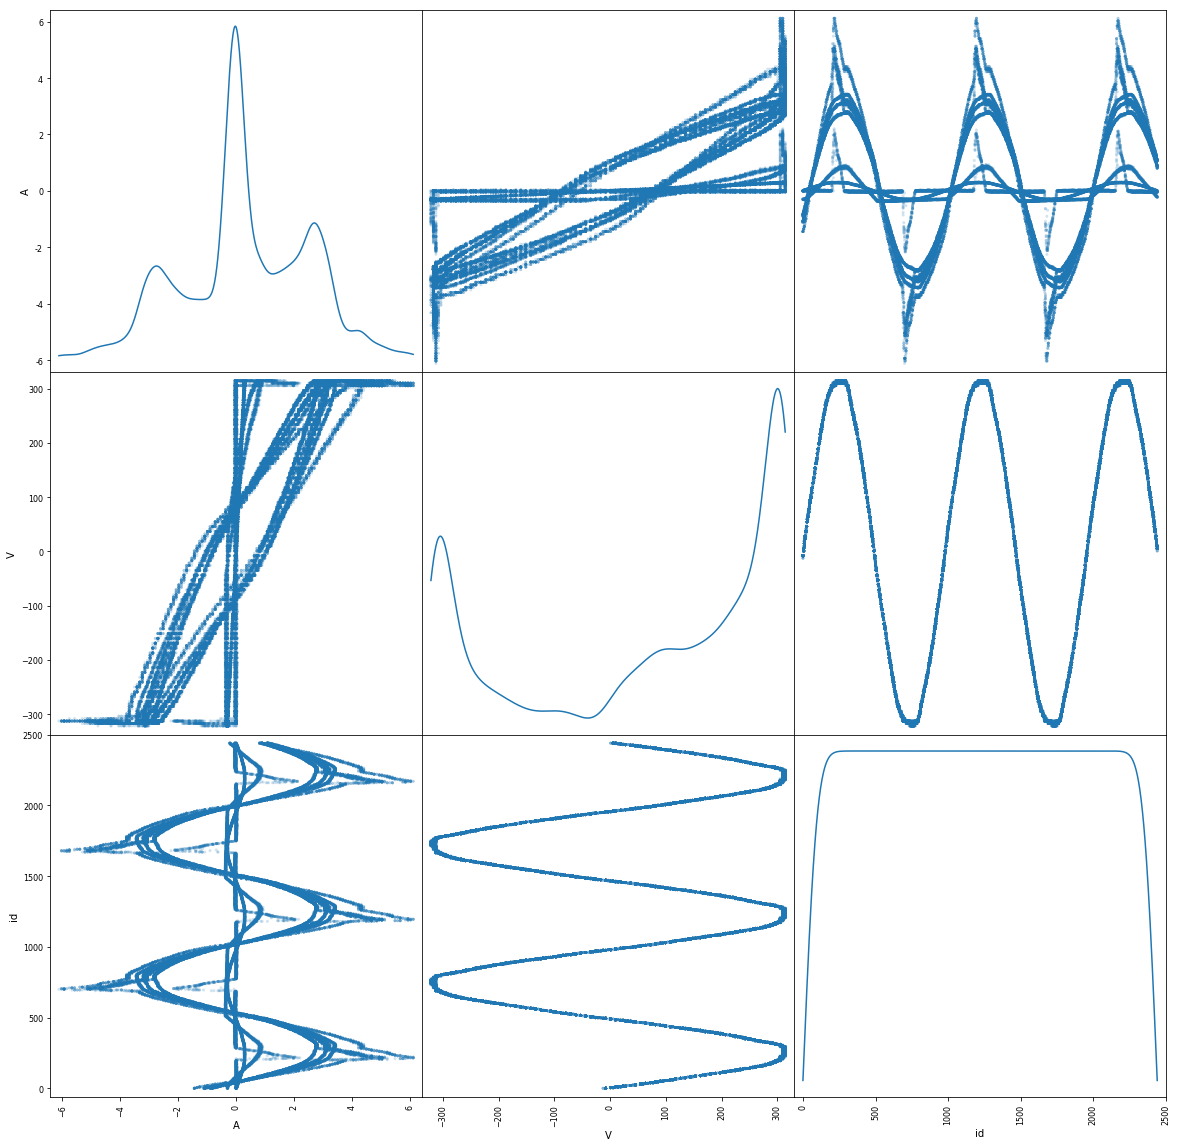

In [10]:
%matplotlib inline
scatter_matrix(features[0::100], alpha=0.2, figsize=(20, 20), diagonal='kde')

## Splitten der Daten und Training

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle=True)

clf = RandomForestClassifier(n_estimators=20, random_state=42, min_samples_split=2, verbose=2, n_jobs=-1)
startTime = time()

clf.fit(X_train, Y_train)

endTime = time()
diff = (endTime - startTime)
print("Time taken:", diff)

building tree 1 of 20building tree 2 of 20building tree 3 of 20building tree 4 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
Time taken: 208.63855290412903


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.5min finished


In [12]:
print("Train:", round(10000*clf.score(X_train, Y_train))/100.0)
print("Test:", round(10000*clf.score(X_test, Y_test))/100.0)

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   19.7s finished


Train: 90.66


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    8.2s finished


Test: 90.38


## Vorhersage eines willkürlich herausgegriffenen Samples

In [13]:
num_test_samples = len(X_test)
sample = np.random.randint(len(X_test))

print("evaluating sample", sample, "of", num_test_samples)
#print(Y_test.head(), type(Y_test))
sample_X = X_test[sample]
sample_Y = Y_test[sample:sample+1]

print(sample_X)
print(sample_Y)

clf.predict(sample_X.reshape(1, -1))

evaluating sample 1610867 of 1877760
[ 0.66422236  0.88731663  0.05728314]
140    5
Name: labels, dtype: uint8


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


array([5], dtype=uint8)

# Modell mit neuen Daten evaluieren und plotten

- Daten aufzeichnen
- Als CSV exportieren
- CSV einlesen
- Für jeden Strom- und Spannungsverlauf in einer Datei (50ms Zeitfenster)
    - Aktives Gerät vorhersagen
    - Ergebnis ist Modus der Vorhersagen

# Konzept
### Welches Gerät wurde am häufigsten innerhalb der 50ms vorhergesagt?

In [14]:
def getPredictionsAndProbabilities(dataframes):
    wave_predictions = []
    wave_probabilities = []

    for wave in dataframes:
        wave = wave.sort_index(axis=1)
        wave = min_max_scaler.transform(wave)
        # predict per sample
        predictions = clf.predict(wave)

        mode = stats.mode(predictions, axis=None)
        wave_predictions.append(mode[0][0])
        wave_probabilities.append(mode[1][0] * 100.0 / len(wave))
        
    return (wave_predictions, wave_probabilities)

### Plotten der Genauigkeit

In [15]:
def plotProbabilities(probs, minY=0, maxY=100):
    %matplotlib inline
    plt.plot(probs)
    plt.ylabel('Percentage')

    axes = plt.gca()
    axes.set_ylim([minY, maxY])
    axes.set_xlim([0,len(probs)-1])
    plt.gcf().set_size_inches(18.5, 10.5)

    plt.show()

### Wann war welches Gerät aktiv?

In [16]:
def plotPredictions(predictions):
    global mapFromIdToLabel
    
    labels = mapFromIdToLabel.columns.values

    begin = []
    end =   []
    events = []

    last_label = -1
    for (index, prediction) in enumerate(predictions):

        if prediction != last_label:
            if last_label != -1:
                end.append(index)

            begin.append(index)
            
            # human readable string if possible
            eventName = labels[prediction]
            if eventName in DEVICE_DESCRIPTIONS:
                eventName = DEVICE_DESCRIPTIONS[eventName]    
            events.append(eventName)
            
            last_label = prediction

    end.append(len(predictions) - 1)

    begin = np.array(begin)
    end = np.array(end)

    # map each activity to a its horizontal origin and width
    xRanges = np.array((begin, end-begin)).T    
    
    eventNames = np.unique(events)
    eventDict = {name: index for index, name in enumerate(eventNames)}
    
    # map each event to a tuple containing its vertical origin and height
    # based on the index in the unique names list (no duplicate entries in plot)
    yRanges = list(map(lambda event: (eventDict[event] - 0.5, 0.8), events))

    # plot the timeline
    %matplotlib inline
    fig, ax = plt.subplots()
    for index, activity in enumerate(xRanges):
        ax.broken_barh([activity], yRanges[index])
    plt.yticks(range(len(eventNames)), eventNames)
    plt.gcf().set_size_inches(18.5, 10.5)
    plt.show()

# Durchführung
### Einlesen und Plotten der neuen Daten 

laptop-single


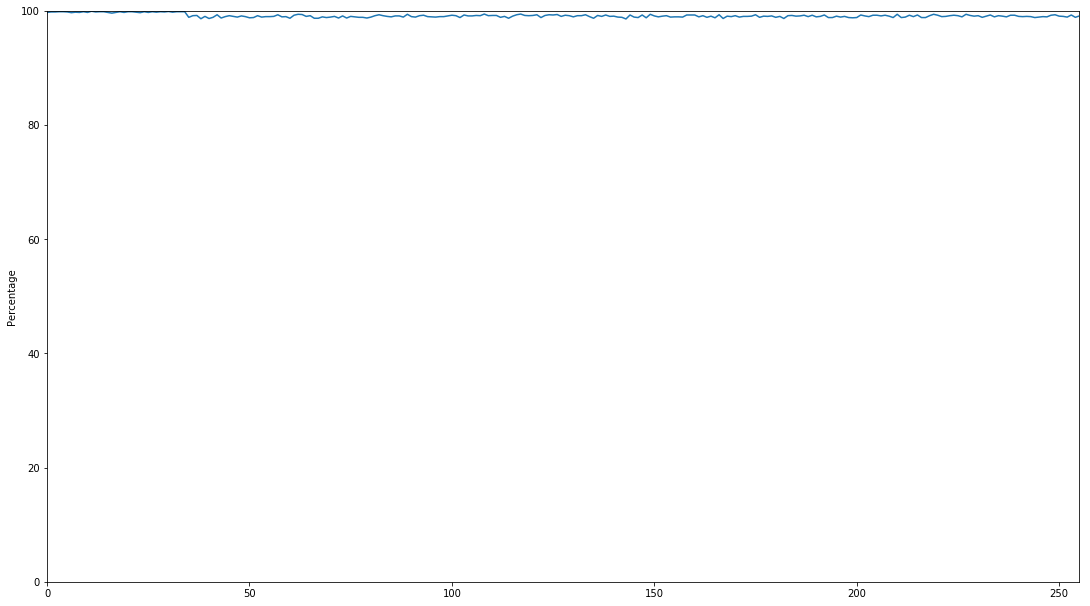

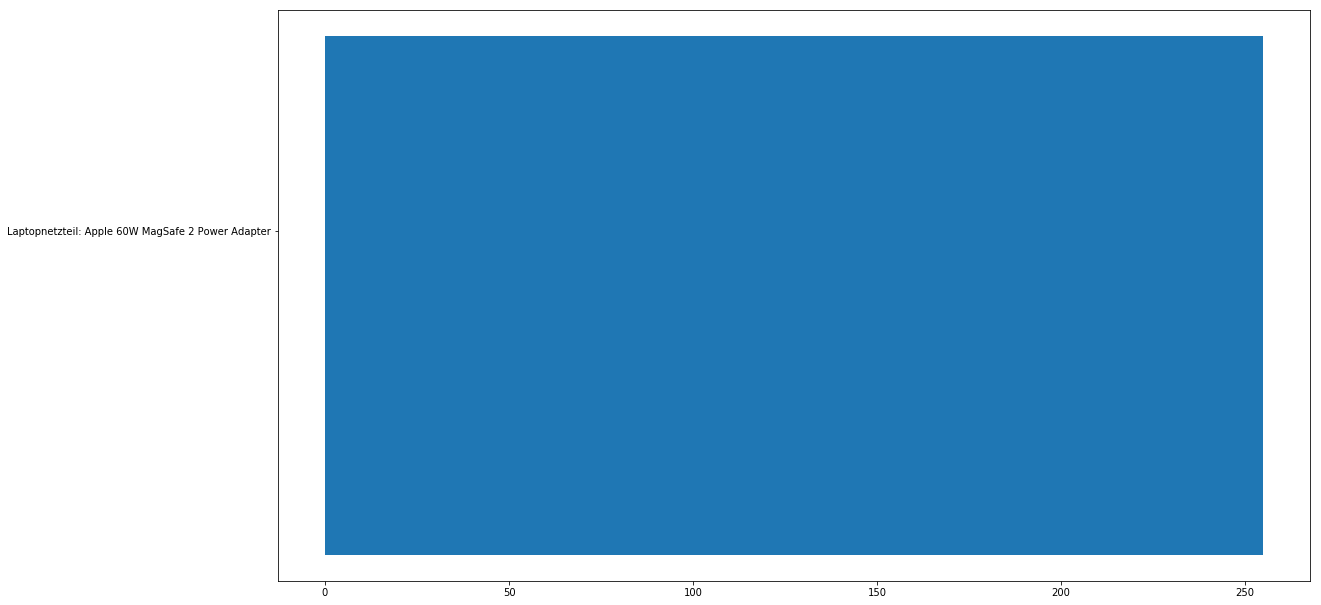

ohp_voll-laptop


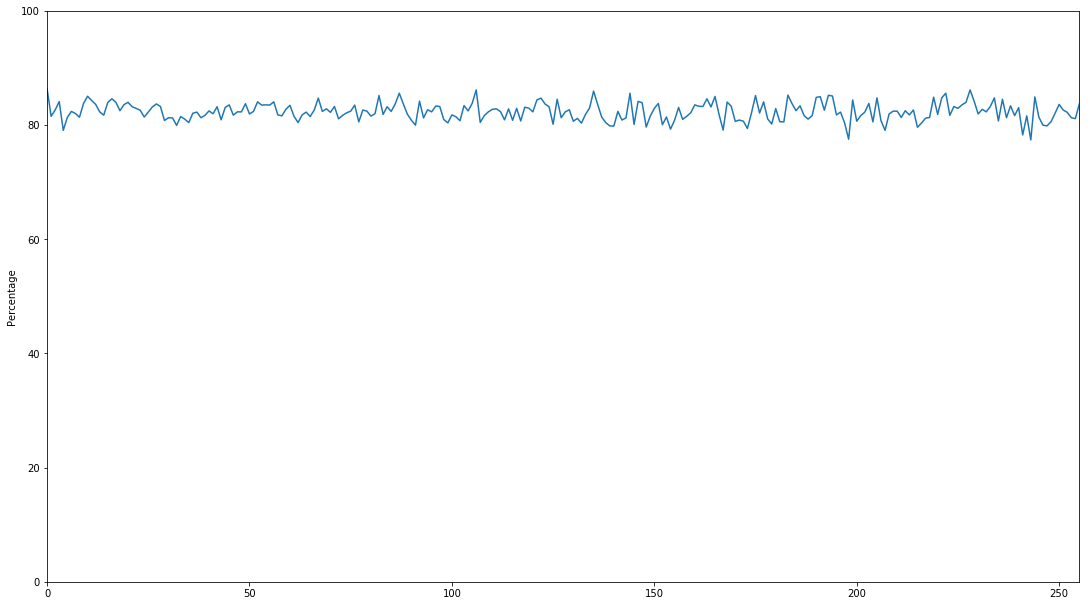

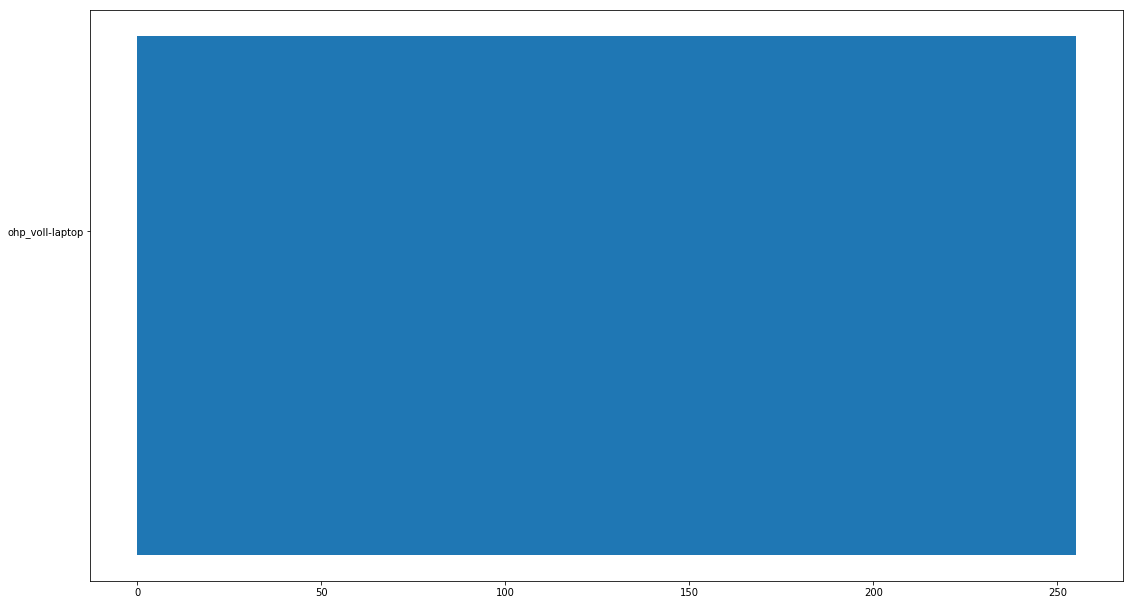

ohp_halb-single


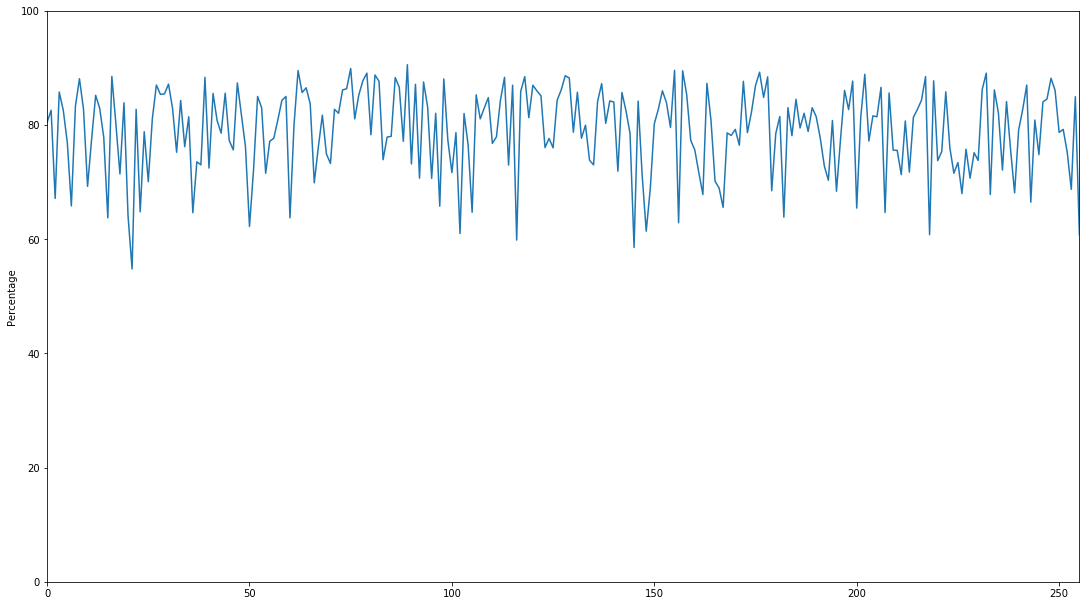

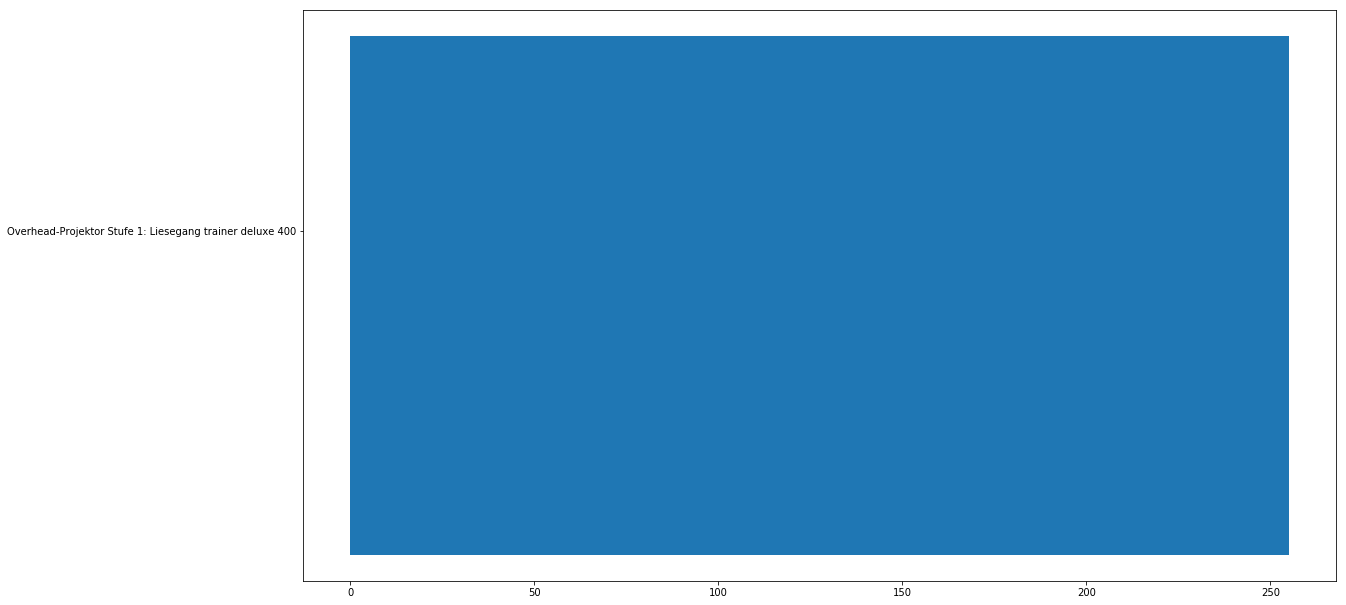

lampe-ohp_voll


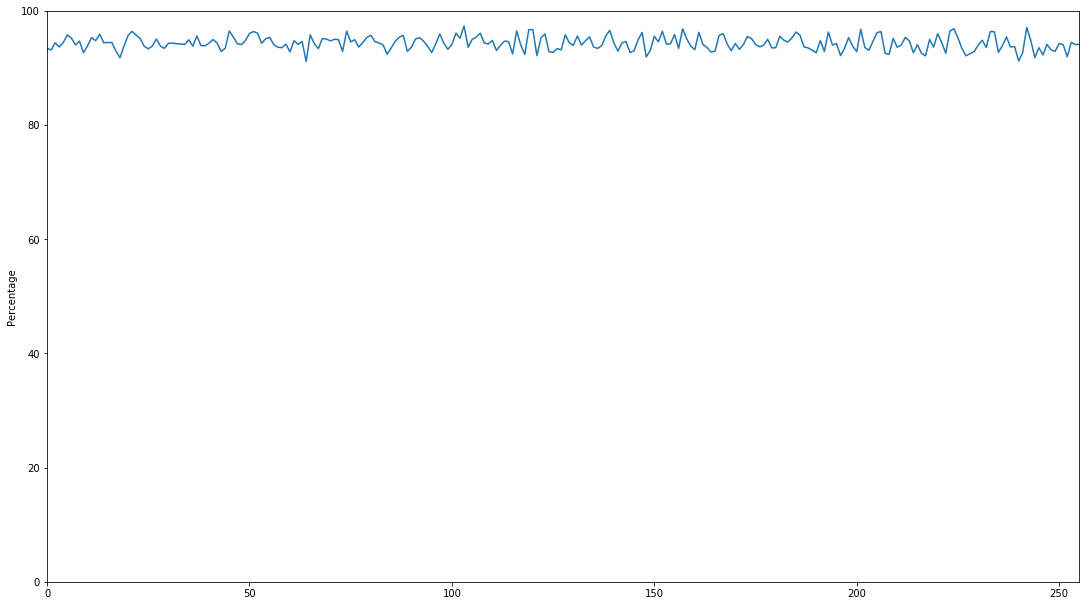

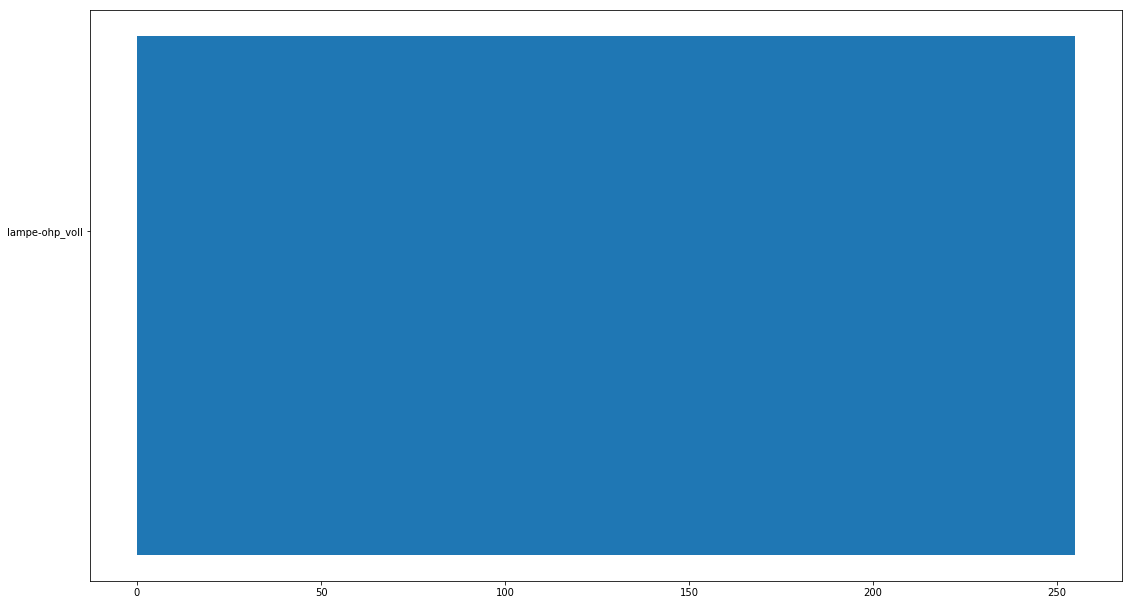

ohp_voll-single


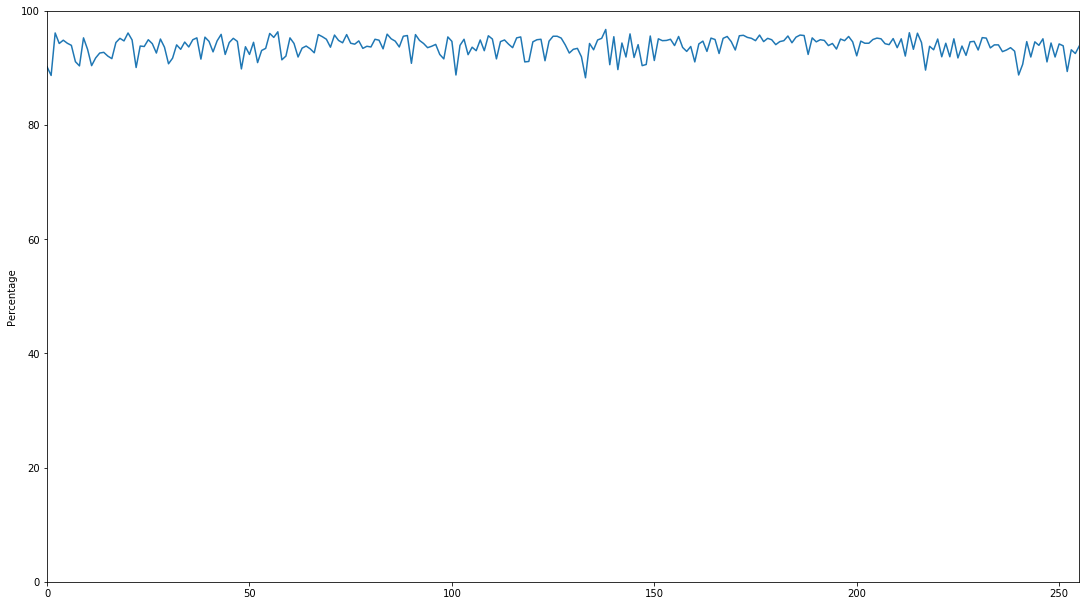

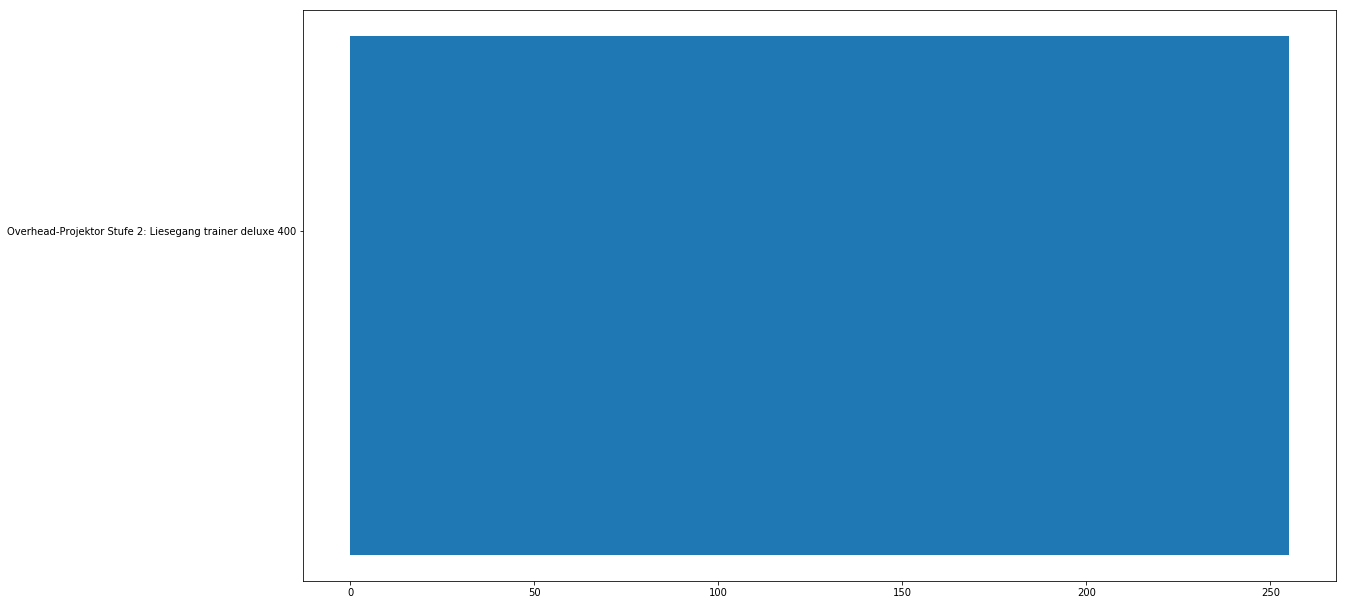

bosch-single


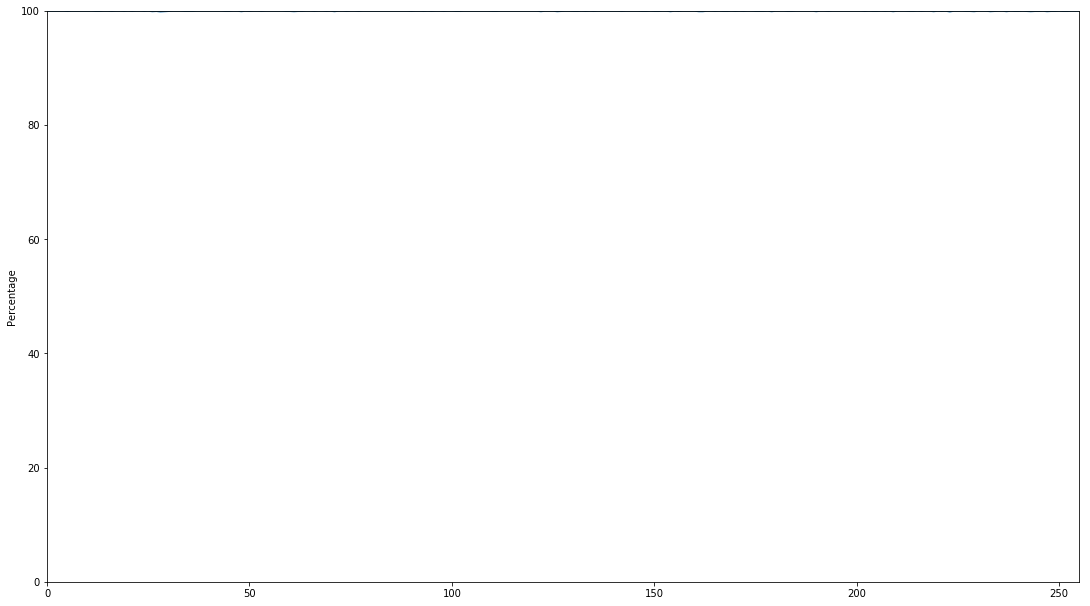

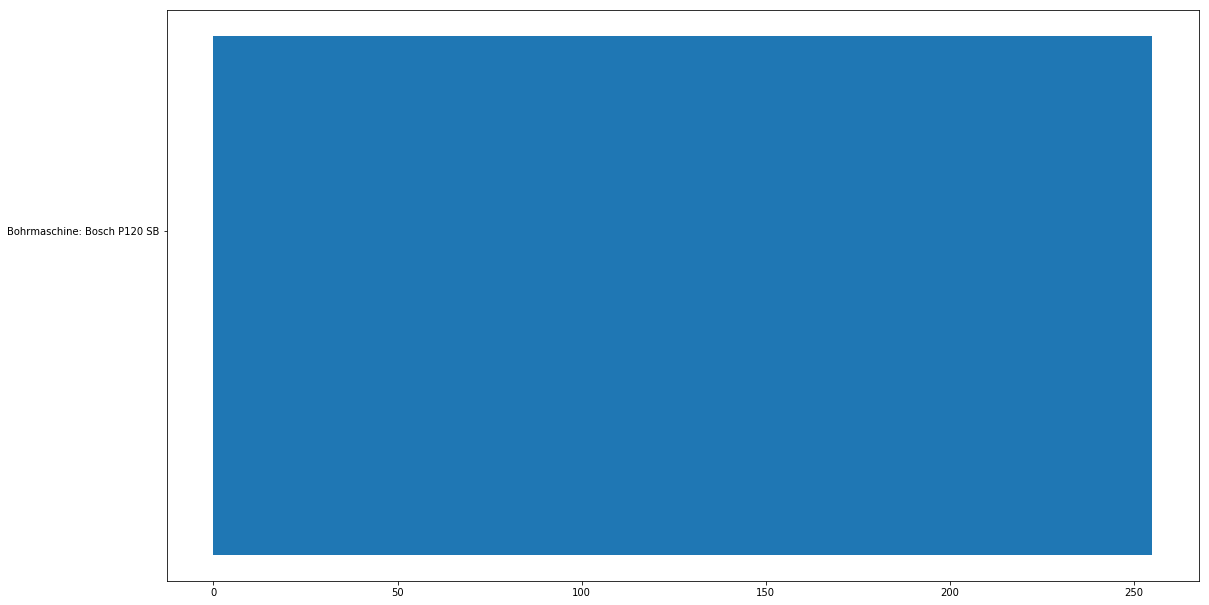

lampe-single


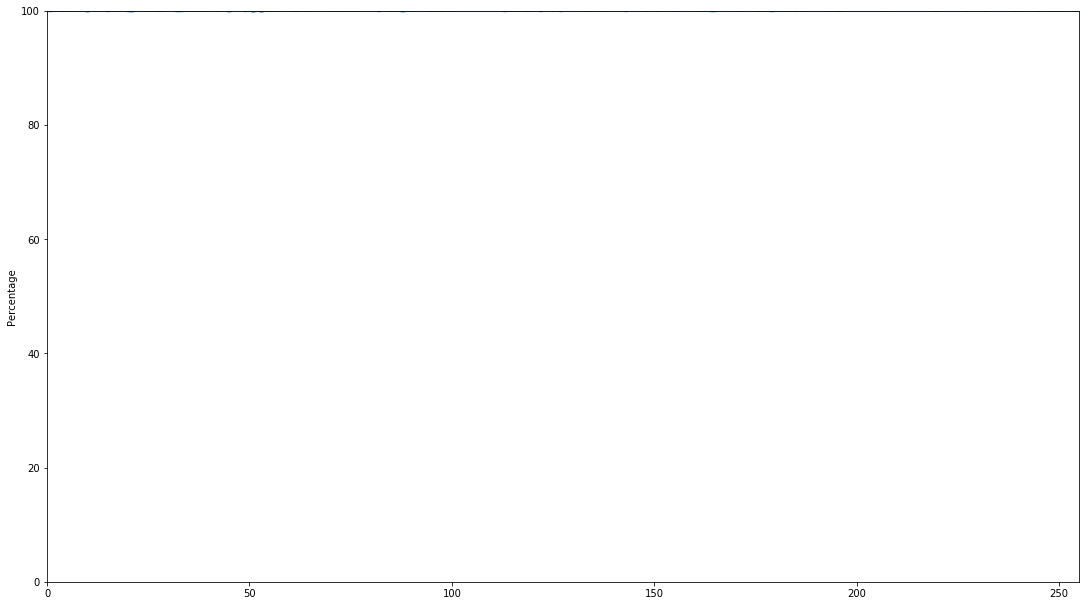

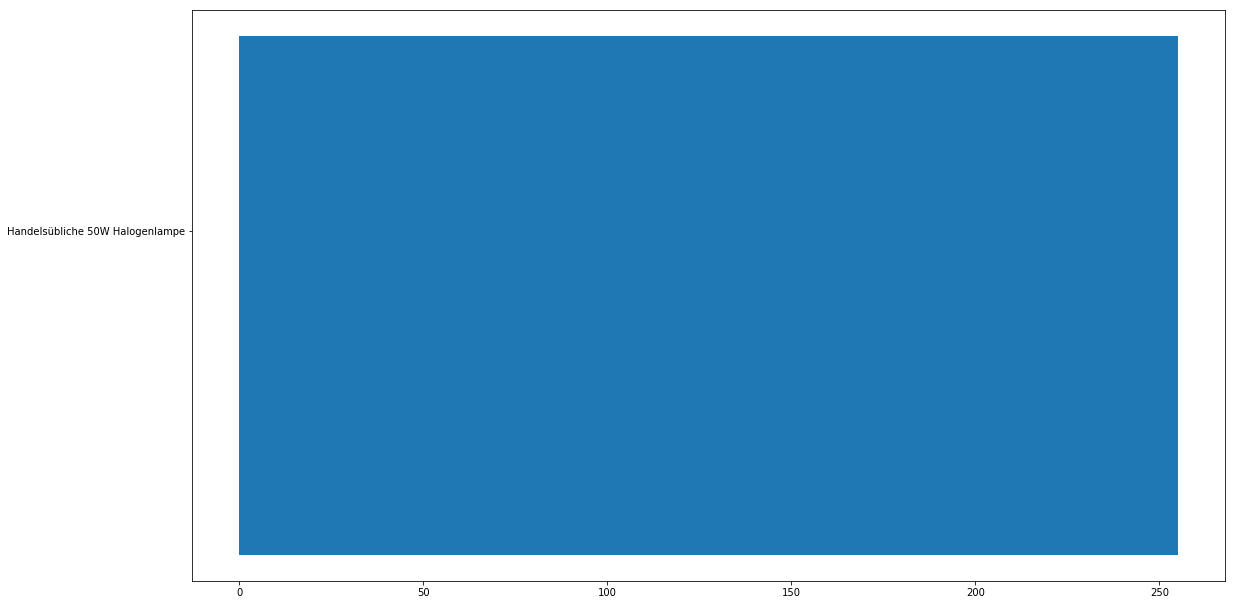

ohp_voll-laptop-bosch-lampe


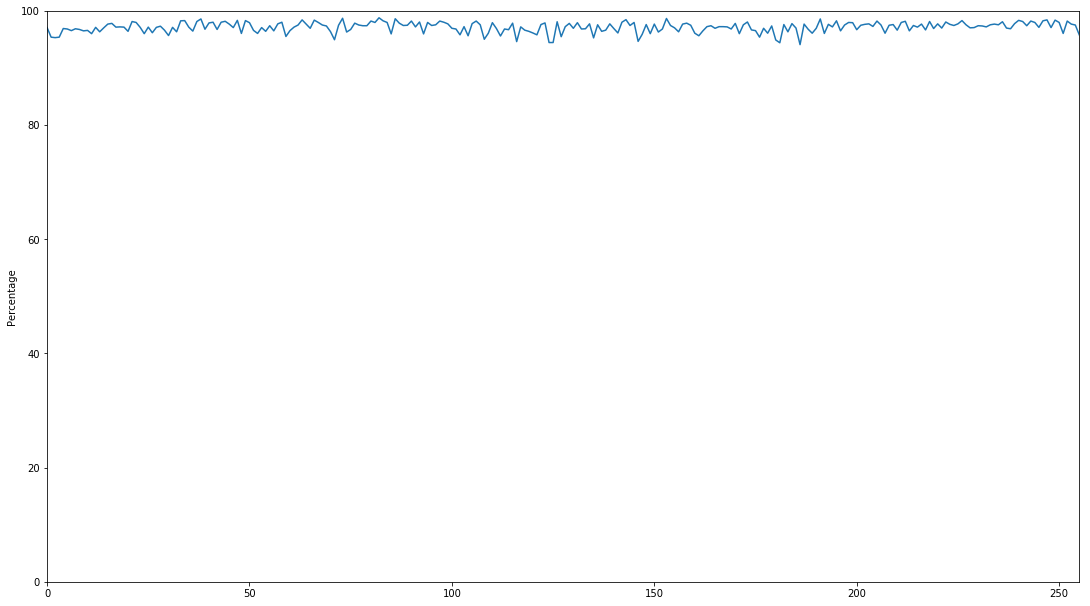

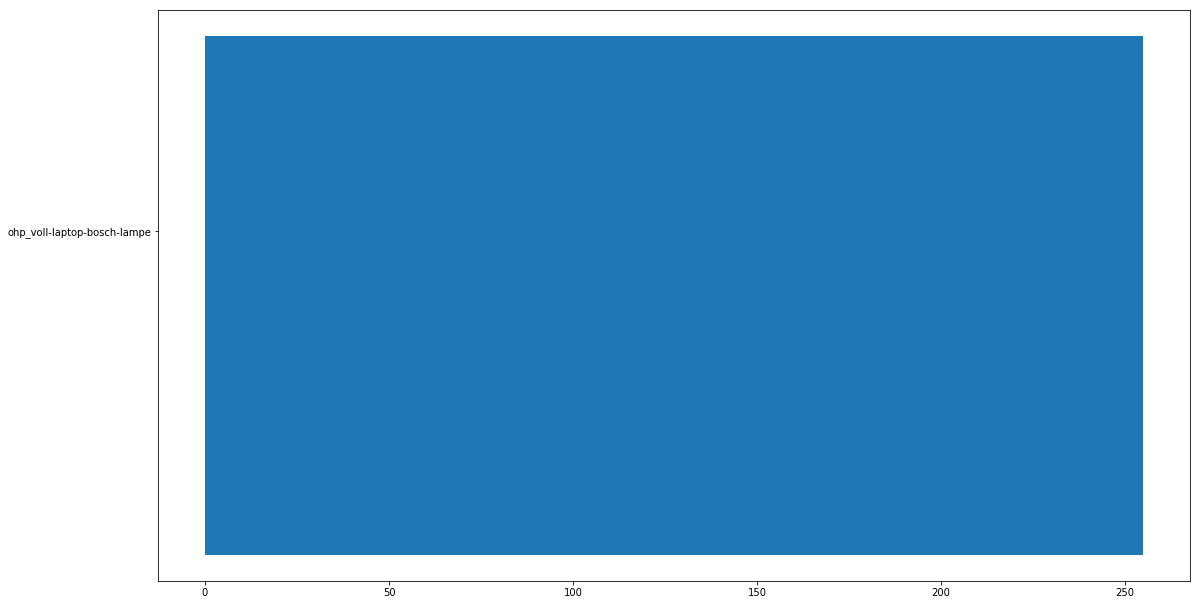

ohp_halb-laptop


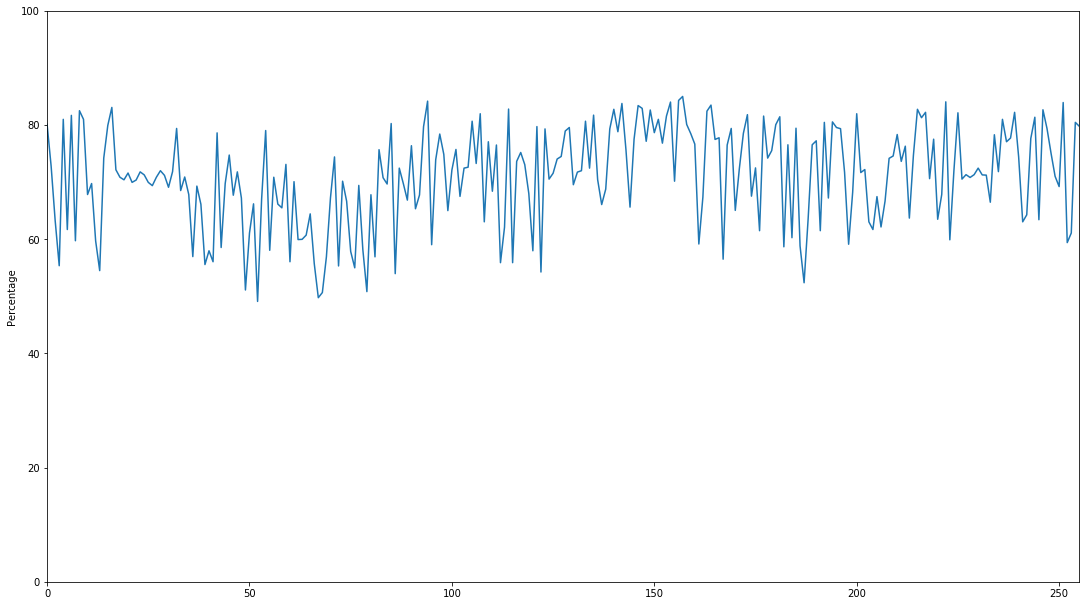

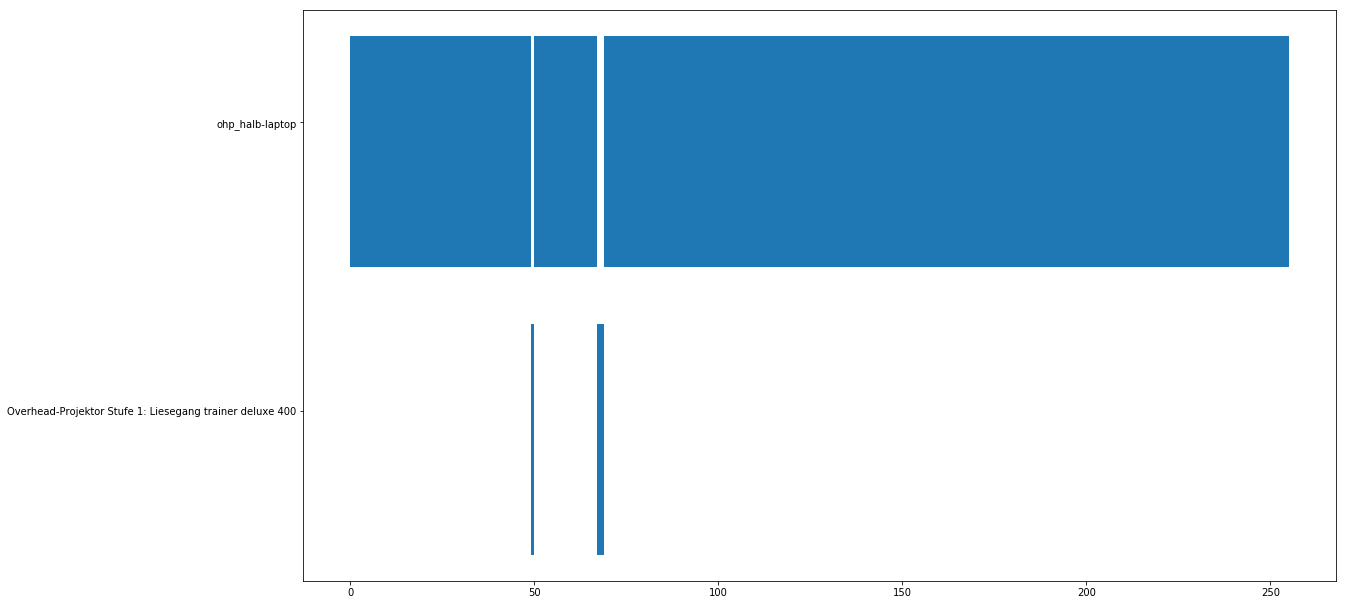

ohp_halb-laptop-lampe


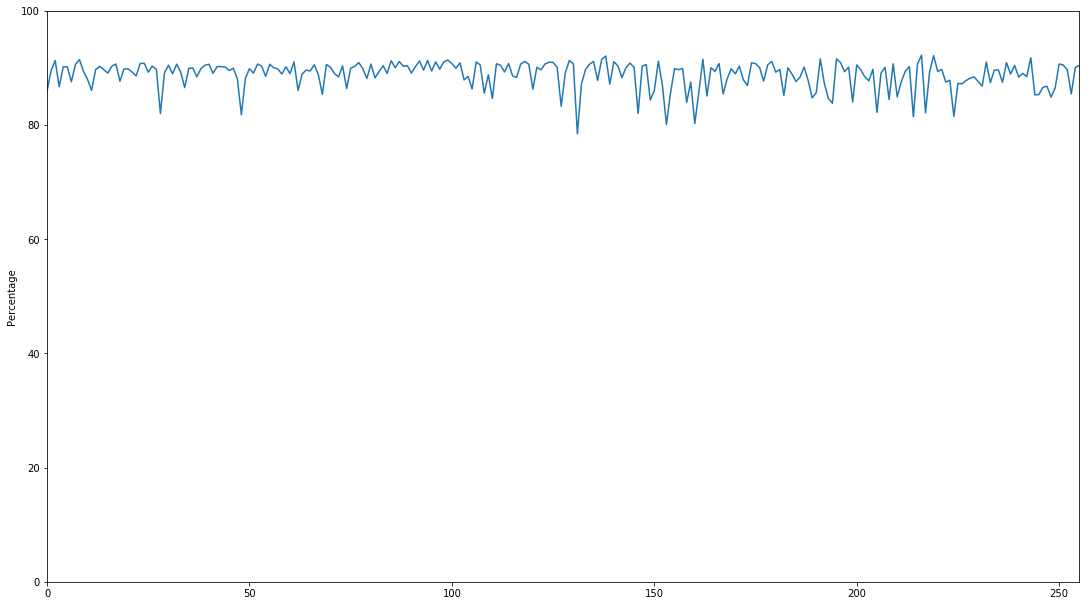

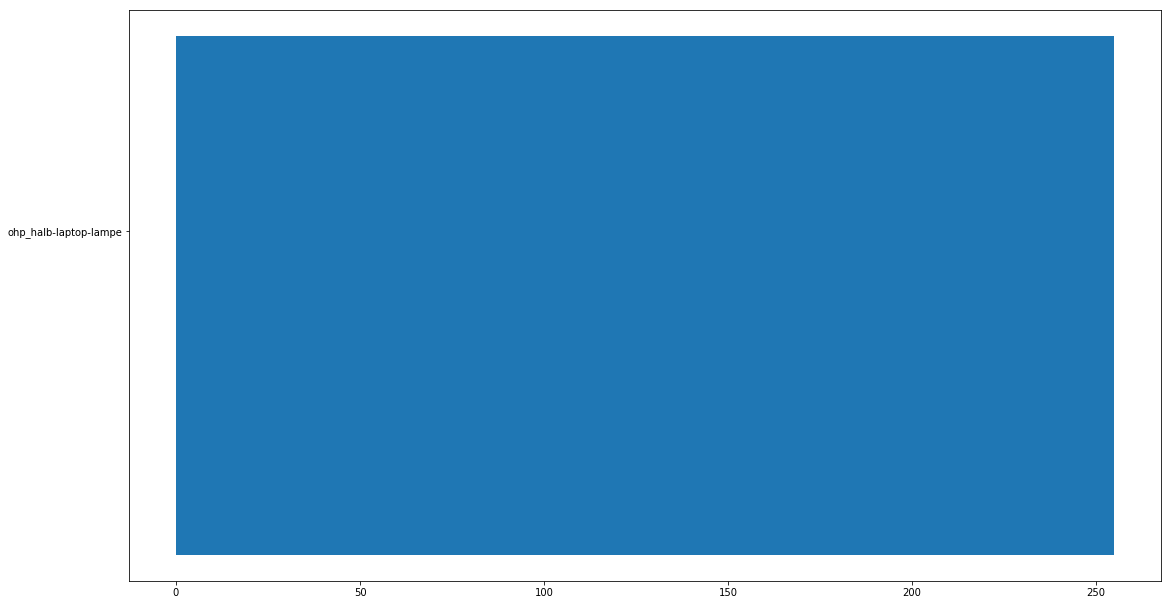

In [17]:
clf.set_params(verbose=0)

for device, dataframes in dataframes_per_directory.items():
    print(device)
    
    #dataframes = getDataFramesFromDirectory("./data/ohp_halb-laptop/")
    wave_predictions, wave_probabilities = getPredictionsAndProbabilities(dataframes)
    plotProbabilities(wave_probabilities, minY=0, maxY=100)
    plotPredictions(wave_predictions)

## Speichern des Modells

In [18]:
joblib.dump(clf, 'trainedModelforFelixandDatascienceProject_longFilenamecausewerecool.pkl') 

['trainedModelforFelixandDatascienceProject_longFilenamecausewerecool.pkl']